In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pytorch_lightning as pl
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc,
    roc_auc_score, precision_recall_curve, average_precision_score
)
from sklearn.preprocessing import label_binarize

import sys
import os

sys.path.insert(0, os.path.join(os.getcwd(), '..', 'model'))
from pedestrian_model import PedestrianRiskClassifier
sys.path.insert(0, os.path.join(os.getcwd(), '..', 'dataset'))
from data_loader_job import load_datasets

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("deep")

In [3]:
path = "/projects/dsci410_510/DAVID-sim/pedestrian-epoch=11-val_loss=0.24-val_acc=0.91.ckpt"
checkpoint_path = path
try:
    model = PedestrianRiskClassifier.load_from_checkpoint(checkpoint_path)
    print("Successfully loaded model from checkpoint.")
except Exception as e:
    print(f"Could not load full model: {e}")
    
    model = PedestrianRiskClassifier()
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    
    try:
        model.load_state_dict(checkpoint['state_dict'])
        print("Successfully loaded model weights.")
    except:
        state_dict = checkpoint['state_dict']
        new_state_dict = {k.replace('model.', ''): v for k, v in state_dict.items()}
        model.load_state_dict(new_state_dict, strict=False)
        print("Successfully loaded model weights with key remapping.")

model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(f"Model loaded and set to {device}")

Successfully loaded model from checkpoint.
Model loaded and set to cuda


In [3]:
_, _, test_loader = load_datasets("pedestrian_risk_analysis.csv")
print("Successfully loaded test dataset.")

Successfully loaded test dataset.


In [4]:
class_labels = {0: "low", 1: "medium", 2: "high"} 

In [5]:
all_preds = []
all_probs = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        if isinstance(batch, list) or isinstance(batch, tuple):
            images, labels = batch[0], batch[1]
       
        images = images.to(device)
        outputs = model(images)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs.data, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_probs.extend(probabilities.cpu().numpy())  
        all_labels.extend(labels.cpu().numpy())

Model Evaluation Results:
Evaluating model performance on 3 classes: ('low', 'medium', 'high')
Accuracy: 0.9109
Precision (weighted): 0.9125
Recall (weighted): 0.9109
F1 Score (weighted): 0.9113

Class-specific metrics:
Class low:
  Samples: 351 (32.6% of dataset)
  Accuracy: 0.9345
  Precision: 0.9136
  Recall: 0.9345
  F1-score: 0.9239
Class medium:
  Samples: 356 (33.1% of dataset)
  Accuracy: 0.8904
  Precision: 0.8591
  Recall: 0.8904
  F1-score: 0.8745
Class high:
  Samples: 370 (34.4% of dataset)
  Accuracy: 0.9081
  Precision: 0.9628
  Recall: 0.9081
  F1-score: 0.9346


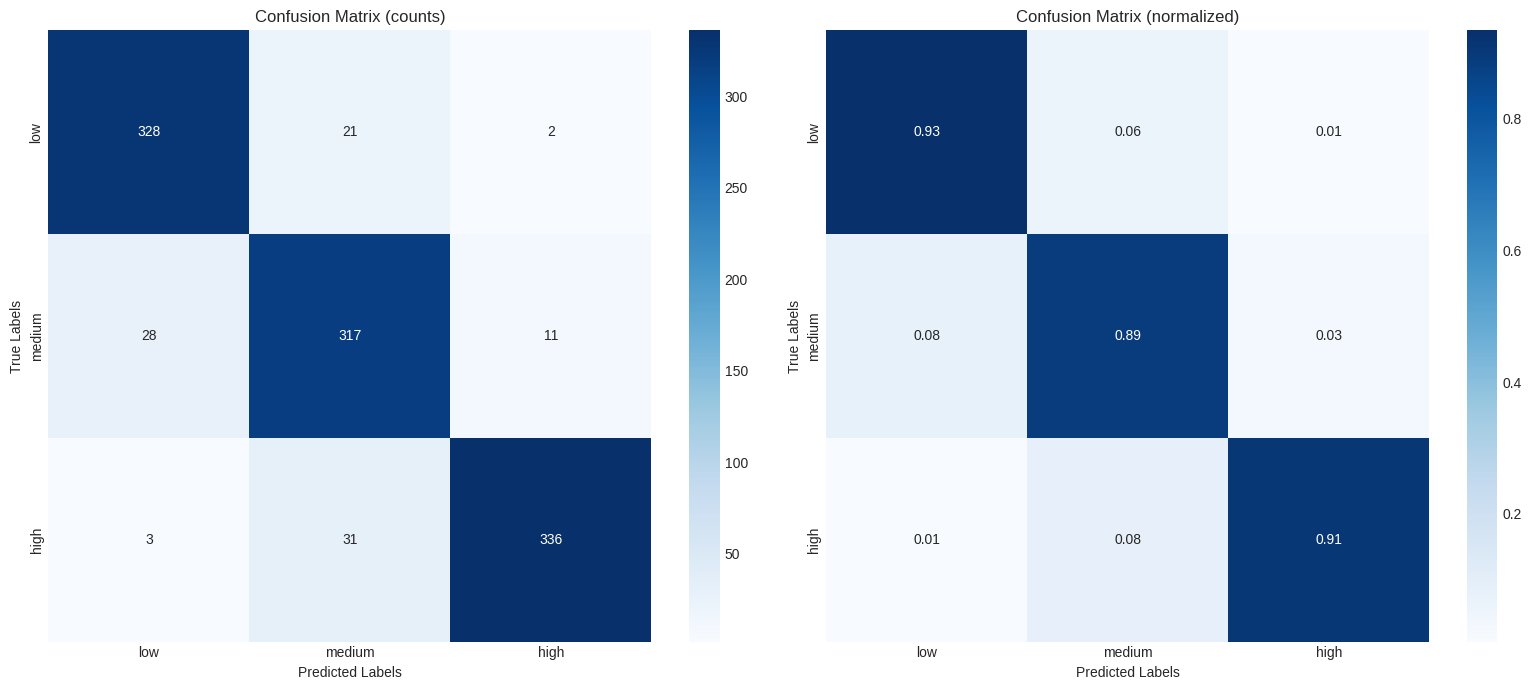


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       351
           1       0.86      0.89      0.87       356
           2       0.96      0.91      0.93       370

    accuracy                           0.91      1077
   macro avg       0.91      0.91      0.91      1077
weighted avg       0.91      0.91      0.91      1077



In [13]:
print("Model Evaluation Results:")
print("=" * 30)

y_test = np.array(all_labels)
y_pred = np.array(all_preds)
y_prob = np.array(all_probs)  

classes = np.unique(y_test)
n_classes = len(classes)
print(f"Evaluating model performance on {n_classes} classes: {class_labels[0],class_labels[1],class_labels[2]}")

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1 Score (weighted): {f1:.4f}")

print("\nClass-specific metrics:")
for i, c in enumerate(classes):
    class_indices = np.where(y_test == c)[0]
    class_count = len(class_indices)
    class_acc = accuracy_score(y_test[class_indices], y_pred[class_indices])
    class_prec = precision_score(y_test, y_pred, labels=[c], average='micro')
    class_rec = recall_score(y_test, y_pred, labels=[c], average='micro')
    class_f1 = f1_score(y_test, y_pred, labels=[c], average='micro')
    
    print(f"Class {class_labels[c]}:")
    print(f"  Samples: {class_count} ({class_count/len(y_test)*100:.1f}% of dataset)")
    print(f"  Accuracy: {class_acc:.4f}")
    print(f"  Precision: {class_prec:.4f}")
    print(f"  Recall: {class_rec:.4f}")
    print(f"  F1-score: {class_f1:.4f}")

cm = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
tick_labels = [class_labels[c] for c in classes]

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1, xticklabels=tick_labels, yticklabels=tick_labels)
ax1.set_xlabel('Predicted Labels')
ax1.set_ylabel('True Labels')
ax1.set_title('Confusion Matrix (counts)')

sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', ax=ax2, xticklabels=tick_labels, yticklabels=tick_labels)
ax2.set_xlabel('Predicted Labels')
ax2.set_ylabel('True Labels')
ax2.set_title('Confusion Matrix (normalized)')

plt.tight_layout()
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

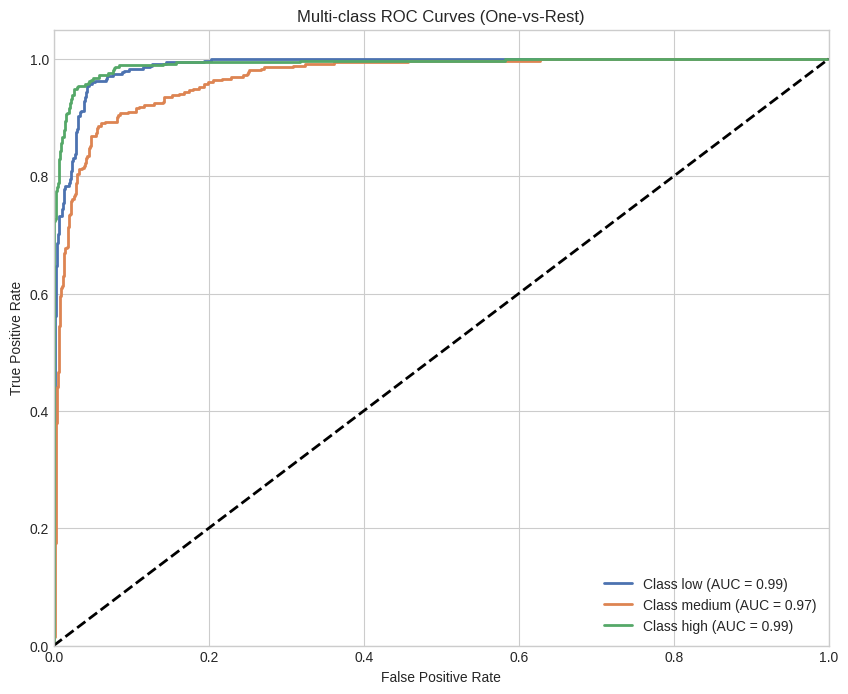


AUC scores for each class (one-vs-rest):
Class low AUC: 0.9885
Class medium AUC: 0.9685
Class high AUC: 0.9920


In [12]:
y_onehot = label_binarize(y_test, classes=classes)
fig, ax = plt.subplots(figsize=(10, 8))

for i, c in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_onehot[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, lw=2, label=f'Class {class_labels[c]} (AUC = {roc_auc:.2f})')

ax.plot([0, 1], [0, 1], 'k--', lw=2)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Multi-class ROC Curves (One-vs-Rest)')
ax.legend(loc="lower right")
plt.show()

print("\nAUC scores for each class (one-vs-rest):")
for i, c in enumerate(classes):
    roc_auc = roc_auc_score(y_onehot[:, i], y_prob[:, i])
    print(f"Class {class_labels[c]} AUC: {roc_auc:.4f}")

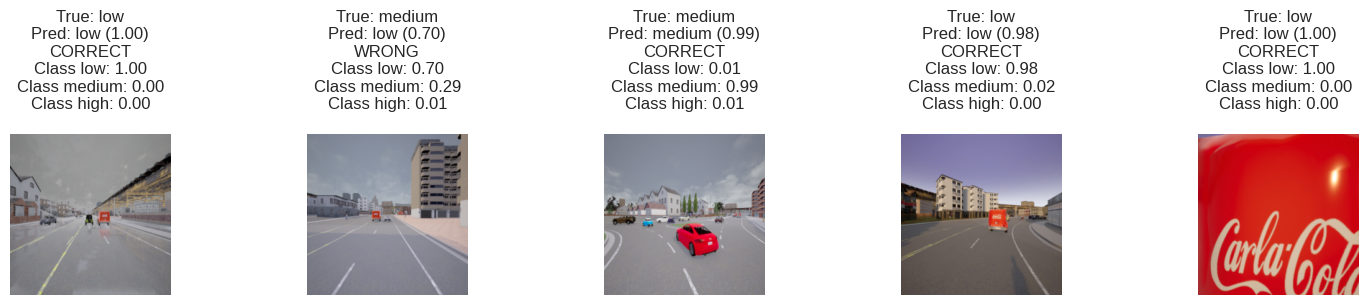

In [11]:
def visualize_sample_predictions(test_loader, model, device, num_samples=5):
    for batch in test_loader:
        if isinstance(batch, list) or isinstance(batch, tuple):
            images, labels = batch[0], batch[1]
            
        indices = np.random.choice(len(images), min(num_samples, len(images)), replace=False)
        fig, axes = plt.subplots(1, len(indices), figsize=(15, 3))
        
        for i, idx in enumerate(indices):
            image = images[idx:idx+1].to(device)
            label = labels[idx].item()
            
            with torch.no_grad():
                output = model(image)
                if isinstance(output, tuple):
                    output = output[0]
                
                prob = torch.nn.functional.softmax(output, dim=1)
                _, pred = torch.max(output, 1)
                pred = pred.item()
                prob_value = prob[0][pred].item()
                
                class_probs = {c: prob[0][c].item() for c in range(len(prob[0]))}
            
            img = images[idx].cpu().permute(1, 2, 0).numpy()
            
            if img.min() < 0 or img.max() > 1:
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                img = img * std + mean
                img = np.clip(img, 0, 1)
            
            axes[i].imshow(img)
            
            correct = "CORRECT" if pred == label else "WRONG"
            title = f"True: {class_labels[label]}\nPred: {class_labels[pred]} ({prob_value:.2f})\n{correct}\n"
            for c, p in class_probs.items():
                title += f"Class {class_labels[c]}: {p:.2f}\n"
            axes[i].set_title(title)
            axes[i].axis('off')
        
        plt.tight_layout()
        plt.show()
        break  

visualize_sample_predictions(test_loader, model, device)

In [9]:
misclassified_indices = np.where(y_pred != y_test)[0]
misclassification_rate = len(misclassified_indices) / len(y_test) * 100
print(f"\nNumber of misclassified examples: {len(misclassified_indices)} out of {len(y_test)} ({misclassification_rate:.2f}%)")

if len(misclassified_indices) > 0:
    error_groups = {}
    for idx in misclassified_indices:
        true_label = y_test[idx]
        pred_label = y_pred[idx]
        key = f"{class_labels[true_label]}->{class_labels[pred_label]}"
        if key not in error_groups:
            error_groups[key] = 0
        error_groups[key] += 1
    
    print("\nError distribution (True->Predicted):")
    for key, count in sorted(error_groups.items(), key=lambda x: -x[1]):
        percentage = count / len(misclassified_indices) * 100
        print(f"  {key}: {count} samples ({percentage:.1f}% of errors)")

    misclassified_confidences = []
    for idx in misclassified_indices:
        pred_class = y_pred[idx]
        confidence = y_prob[idx][pred_class]
        misclassified_confidences.append(confidence)
    
    avg_misclassification_confidence = np.mean(misclassified_confidences)
    print(f"\nAverage confidence on misclassifications: {avg_misclassification_confidence:.4f}")


Number of misclassified examples: 96 out of 1077 (8.91%)

Error distribution (True->Predicted):
  high->medium: 31 samples (32.3% of errors)
  medium->low: 28 samples (29.2% of errors)
  low->medium: 21 samples (21.9% of errors)
  medium->high: 11 samples (11.5% of errors)
  high->low: 3 samples (3.1% of errors)
  low->high: 2 samples (2.1% of errors)

Average confidence on misclassifications: 0.7188


In [10]:
results_df = pd.DataFrame({
    'true_label': y_test,
})

results_df['predicted_label'] = y_pred

for i in range(y_prob.shape[1]):
    results_df[f'prob_class_{i}'] = y_prob[:, i]

results_df['correct'] = y_test == y_pred

confidence_threshold = 0.8 
results_df['high_conf_wrong'] = (results_df['correct'] == False) & (results_df.filter(like='prob_class_').max(axis=1) > confidence_threshold)

results_df.to_csv('pedestrian_model_evaluation_results.csv', index=False)

print("\nEvaluation completed! Results saved to pedestrian_model_evaluation_results.csv")


Evaluation completed! Results saved to pedestrian_model_evaluation_results.csv
